In [1]:
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir,os.pardir))
os.chdir(parent_dir)

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from vae_earlystopping import EarlyStopping
from model.m26odel_bce import MultiDecoderCondVAE
from loss.l26oss_bce import integrated_loss_fn

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_loader = torch.load('torch/pre_retrain_loader.pt',weights_only= False)
val_loader = torch.load('torch/pre_reval_loader.pt',weights_only = False)
test_loader = torch.load('torch/pre_retest_loader.pt',weights_only=False)

In [5]:
x_sample,c_sample = next(iter(train_loader))
x_dim = x_sample.shape[1]
c_dim = c_sample.shape[1]

In [6]:
model = MultiDecoderCondVAE(x_dim=x_dim,c_dim=c_dim,z_dim = 8 ).to(device)
early_stopping = EarlyStopping(patience = 40, min_delta = 1e-9)
optimizer = optim.Adam(model.parameters(),lr = 1e-3, weight_decay = 1e-5)

In [7]:
history = {'train_loss':[],'train_bce':[],'train_kl':[],'val_loss':[],'val_bce':[],'val_kl':[]}
epochs = 400

## pos_weight 추가

In [8]:
def compute_pos_weight(train_loader, device):
    pos = 0
    neg = 0
    with torch.no_grad():
        for x, _ in train_loader:
            x = x.to(device)
            x_binary = (x > 0).float()
            pos += x_binary.sum().item()
            neg += x_binary.numel() - x_binary.sum().item()

    w = neg / (pos + 1e-8)
    return torch.tensor([w], device=device)


In [9]:
pos_weight = compute_pos_weight(train_loader, device)
print("pos_weight =", pos_weight.item())


pos_weight = 14.388333320617676


### train_val 시작 (beta = 1.0, gamma = 1.0)

In [10]:
for epoch in range(1,1+epochs):
    model.train()
    t_loss, t_bce, t_kl = 0,0,0
    for x,c in train_loader:
        x = x.to(device)
        c = c.to(device)
        optimizer.zero_grad()
        bce_logit, prob_mask, binary_out, mu,logvar = model(x,c)
        loss_dict= integrated_loss_fn(bce_logit,x,mu,logvar,pos_weight)
        loss_dict['loss'].backward()
        optimizer.step()
        t_loss +=loss_dict['loss'].item()
        t_bce += loss_dict['bce_loss'].item()
        t_kl += loss_dict['kl_loss'].item()

    model.eval()
    v_loss,v_bce,v_kl = 0,0,0
    with torch.no_grad():
        for v_x,v_c in val_loader:
            v_x,v_c = v_x.to(device),v_c.to(device)
            v_bce_logit,v_prob_mask,v_binary_out, v_mu, v_logvar = model(v_x,v_c)
            v_loss_dict = integrated_loss_fn(v_bce_logit,v_x, v_mu, v_logvar,pos_weight)
            v_loss += v_loss_dict['loss'].item()
            v_bce += v_loss_dict['bce_loss'].item()
            v_kl += v_loss_dict['kl_loss'].item()

    avg_train_loss = t_loss/len(train_loader)
    avg_val_loss = v_loss/len(val_loader)
    history['train_loss'].append(t_loss/len(train_loader))
    history['train_bce'].append(t_bce/len(train_loader))
    history['train_kl'].append(t_kl/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['val_bce'].append(v_bce/len(val_loader))
    history['val_kl'].append(v_kl/len(val_loader))
    
    if epoch % 20 ==0  or epoch ==2:
        print(f'Epoch [{epoch}/{epochs}]|Train:{avg_train_loss:.4f} |Val:{avg_val_loss:.4f}')
    if early_stopping(avg_val_loss,model):
        break

   


Epoch [2/400]|Train:2.2832 |Val:2.0392
Epoch [20/400]|Train:0.9621 |Val:0.9602
Epoch [40/400]|Train:0.5957 |Val:0.6287
EarlyStopping counter: 1 out of 40
Epoch [60/400]|Train:0.4520 |Val:0.5077
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
Epoch [80/400]|Train:0.3848 |Val:0.4590
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
Epoch [100/400]|Train:0.3499 |Val:0.4351
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 

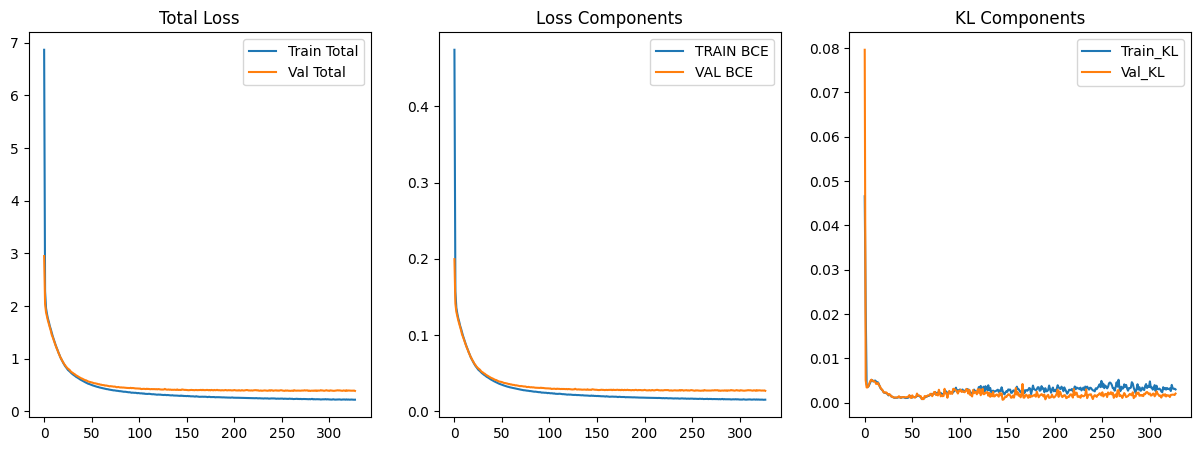

In [11]:
# 5. 결과 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Total')
plt.plot(history['val_loss'], label='Val Total')
plt.title('Total Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_bce'], label='TRAIN BCE')
plt.plot(history['val_bce'], label='VAL BCE')
plt.title('Loss Components')
plt.legend()

plt.subplot(1,3,3)
plt.plot(history['train_kl'],label ='Train_KL')
plt.plot(history['val_kl'], label = 'Val_KL')
plt.title('KL Components')
plt.legend()
plt.show()

### test 계산

In [12]:
from bce_metrics.bce_solve import eval_bce_metrics

In [13]:
early_stopping.load_best_model(model)
model.eval()
all_x_hat = []
all_x_true = []
with torch.no_grad():
    for x_t,c_t in test_loader:
        x_t,c_t = x_t.to(device),c_t.to(device)
        t_bce_logit,t_prob_mask,t_binary_out,t_mu,t_logvar = model(x_t,c_t)
        x_true = (x_t>0).float()
        all_x_hat.append(t_bce_logit.detach().cpu())
        all_x_true.append(x_true.detach().cpu())
all_x_hat = torch.cat([a.flatten() for a in all_x_hat])
all_x_true = torch.cat([a.flatten() for a in all_x_true])

metrics = eval_bce_metrics(all_x_hat,all_x_true,threshold=0.5)
metrics
        

Restored best model with loss: 0.388232


{'threshold': 0.5,
 'bce': 0.023989681154489517,
 'tp': 1624,
 'fp': 114,
 'tn': 25322,
 'fn': 126,
 'precision': 0.9344073647817354,
 'recall': 0.9279999999946972,
 'f1': 0.9311926555451786,
 'accuracy': 0.9911719267266272}